In [48]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from lstm_sine import SineData

<IPython.core.display.Javascript object>

In [49]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


<IPython.core.display.Javascript object>

In [50]:
if torch.cuda.is_available():
    device = "cuda:1"
else:
    print("Gpu not found")
    device = "cpu"

<IPython.core.display.Javascript object>

In [51]:
class LSTMModel(nn.Module):
    def __init__(self, nodes=10, layers=1, memory=15, dropout=0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=nodes, num_layers=layers, dropout=dropout
        )
        self.out = nn.Linear(nodes, 1)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        return self.out(h_n[-1])

<IPython.core.display.Javascript object>

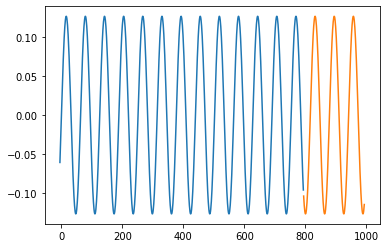

<IPython.core.display.Javascript object>

In [52]:
waves = 150
f = 100
sample = 1000
future = 200
T = sample / f
if future >= sample:
    raise ValueError("Increase sample to be > future!")
# x =  torch.from_numpy(np.swapaxes( np.arange(0, sample) + np.zeros((waves, sample)),0,1)[:, :, np.newaxis]).float().to(device)
x = (
    torch.from_numpy(
        np.swapaxes(
            np.arange(0, sample) + np.random.randint(-4 * T, 4 * T, size=(waves, 1)),
            0,
            1,
        )[:, :, np.newaxis]
    )
    .float()
    .to(device)
)

print()


x_future = x[-future:]
x = x[:-future]
# with torch.no_grad():
random_amps = (
    torch.from_numpy(
        (10 ** (np.random.uniform(np.log10(0.1), np.log10(2), size=[waves, 1])))
    )
    .float()
    .to(device)
)
y_future = torch.sin(x_future / T) * random_amps
y = torch.sin(x / T) * random_amps
plt.plot(x.cpu().detach()[:, 0], y.cpu().detach()[:, 0])
plt.plot(x_future.cpu().detach()[:, 0], y_future.cpu().detach()[:, 0])
plt.show()

In [53]:
model = LSTMModel(nodes=51, layers=3, dropout=0).to(device)
model = torch.jit.script(model)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.MSELoss()
model.train()

for i in range(100):

    def closure():
        optimizer.zero_grad()
        # print(x)
        # exit()
        y_pred = model.forward(y[:-1])
        # print(y_pred.shape)
        # exit()
        loss = loss_func(y_pred, y[-1])
        print(f"Epoch {i}: {loss.item()}")
        loss.backward()
        return loss

    loss = closure()
    # optimizer.step()
    optimizer.step(closure)

Epoch 0: 0.33412671089172363
Epoch 0: 0.33412671089172363
Epoch 0: 0.3330105245113373
Epoch 0: 0.33100318908691406
Epoch 0: 0.3293355107307434
Epoch 0: 0.3279443383216858
Epoch 0: 0.326777845621109
Epoch 0: 0.3257933259010315
Epoch 0: 0.32495564222335815
Epoch 0: 0.3242360055446625
Epoch 0: 0.3236106336116791
Epoch 0: 0.32305994629859924
Epoch 0: 0.3225677013397217
Epoch 0: 0.32211992144584656
Epoch 0: 0.32170480489730835
Epoch 0: 0.3213118016719818
Epoch 0: 0.3209313154220581
Epoch 0: 0.32055389881134033
Epoch 0: 0.32016992568969727
Epoch 0: 0.31976884603500366
Epoch 0: 0.31933778524398804
Epoch 1: 0.3188602328300476
Epoch 1: 0.3188602328300476
Epoch 1: 0.31831252574920654
Epoch 1: 0.3176575005054474
Epoch 1: 0.31682878732681274
Epoch 1: 0.3156851828098297
Epoch 1: 0.31381845474243164
Epoch 1: 0.30862024426460266
Epoch 1: 0.3020477592945099
Epoch 1: 0.2908864915370941
Epoch 1: 0.26735636591911316
Epoch 1: 0.21497300267219543
Epoch 1: 0.14828716218471527
Epoch 1: 0.11448939144611359
Ep

<IPython.core.display.Javascript object>

In [59]:
# sample_plot = 2
with torch.no_grad():
    y_pred = torch.zeros(y.size(0) + future, waves, 1, device=device)
    y_pred[: y.size(0)] = y
    for i in range(future):
        y_pred[y.size(0) + i] = model.forward(y_pred[: y.size(0) + i])
    print(
        f"With {future} predicted points on a batch of {waves} we get a loss of {loss_func(y_pred[y.size(0):], y_future):.2e}"
    )
    y_pred = y_pred.cpu().detach()

With 200 predicted points on a batch of 150 we get a loss of 2.87e-03


<IPython.core.display.Javascript object>

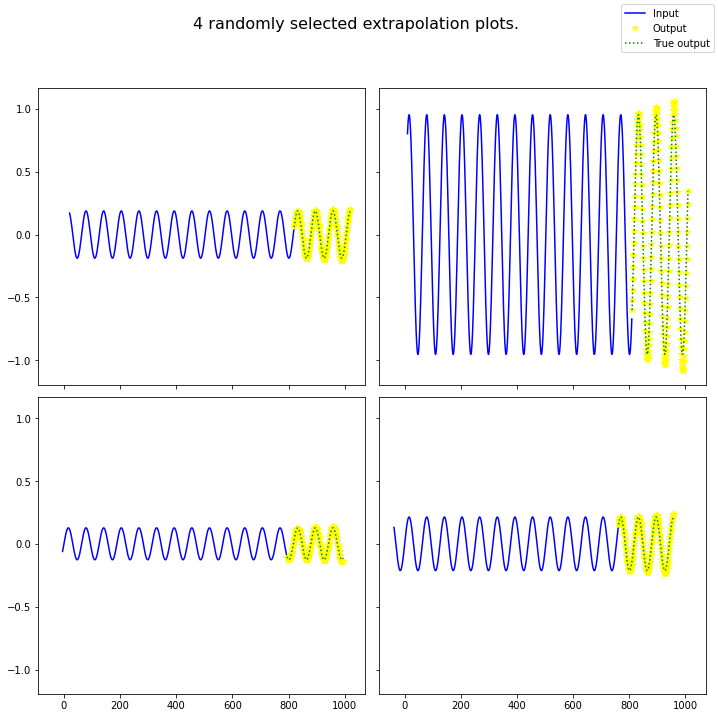

<IPython.core.display.Javascript object>

In [65]:
plots = 4
rows = 2
plot_indices = np.random.choice(np.arange(waves), size=[plots], replace=False)
fig, ax = plt.subplots(plots // rows, rows, figsize=[10, 10], sharex=True, sharey=True)
ax = ax.flatten()
# print(len(ax), waves)
for i, index in enumerate(plot_indices):
    ax[i].plot(x[:, index].cpu().detach(), y_pred[: y.size(0), index], color="blue")
    ax[i].plot(
        x_future[:, index].cpu().detach(),
        y_pred[y.size(0) :, index],
        "*",
        color="yellow",
    )
    ax[i].plot(
        x_future[:, index].cpu().detach(),
        y_future[:, index].cpu().detach(),
        ":",
        color="green",
    )
fig.legend(["Input", "Output", "True output"])
fig.suptitle(f"{plots} randomly selected extrapolation plots.", size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.savefig("random.pdf", dpi=1000)
plt.show()